In [229]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math

# Problem definiton

This section will define the enviroment for the problem. For this simulation, the problem used is the Traveling Saleman Problem, where given a map of cities it should find the optimal path with the least distance passing all the cities exactly once and returning to start point. 

In [325]:

"""
Create map of cities 
Args:
    number_cities: number of cities in the map
    size_map: maximum size of map, cities will be generated between 0 and this variable
Returns:
    array of tuple (x,y) corresponding to cities
"""
def create_map(number_cities, size_map):
    city_map = []
    r = int(size_map*.5)
    random.seed(2023)
    for _ in range(number_cities):
        theta = 2*math.pi*random.random()
        x = r*math.cos(theta) + np.random.normal(5,2, 1)
        y = r*math.sin(theta) + np.random.normal(5,2, 1)
        city_map.append((x,y))
    return city_map

"""
Plot entire map
Args:
    city_map: array of tuple (x,y) corresponding to the cities
"""
def show_map(city_map):
    x_val = [x[0] for x in city_map]
    y_val = [x[1] for x in city_map]
    plt.scatter(x_val,y_val)
    plt.show()
    
"""
Plot entire map with corresponding path
Args:
    city_map: array of tuple (x,y) corresponding to the cities
    path: path to be plotted (array of ints with index of map)
"""    
def show_path(city_map, path):
    x_val = [x[0] for x in city_map]
    y_val = [x[1] for x in city_map]
    plt.scatter(x_val,y_val)
    x_path = [city_map[x][0] for x in path]
    y_path = [city_map[x][1] for x in path]
    plt.plot(x_path, y_path, linestyle="-")
    plt.show()

"""
Plot evolution of GA algorithm
Args:
    avg_fit: list of average fitness per generation
    best_fit: list of best fitess per generation
    patience: patience used for GA
    epochs: epochs used for GA
""" 
def plot_ga(avg_fit,best_fit, patience, epochs):
    figure, axis = plt.subplots(1, 2, figsize=(10, 3)) 
    figure.subplots_adjust(top=0.8)

    figure.suptitle(f"({patience} patience | {epochs} epochs)",y=0.98)
    axis[0].plot(avg_fit) 
    axis[0].set_title(f"Average distance ")
    axis[0].set_ylabel('Distance')
    axis[0].set_xlabel('Generation')    
    axis[1].plot(best_fit) 
    axis[1].set_title(f"Best distance")
    axis[1].set_ylabel('Distance')
    axis[1].set_xlabel('Generation')    
    plt.show()

"""
Plot evolution of paths in GA algorithm
Args:
    city_map: array of tuple (x,y) corresponding to the cities
    path: list of path to be plotted (array of ints with index of map)
""" 
def plot_path_evolution(city_map,paths):
    figure, axis = plt.subplots(1, 2, figsize=(10, 5)) 
    figure.subplots_adjust(top=0.8)
    figure.suptitle(f"Path evolution",y=0.98)
    
    x_val = [x[0] for x in city_map]
    y_val = [x[1] for x in city_map]
    axis[0].scatter(x_val,y_val)
    x_path = [city_map[x][0] for x in paths[0].path]
    y_path = [city_map[x][1] for x in paths[0].path]
    axis[0].plot(x_path, y_path, linestyle="-", color="orange", alpha=0.6)
    axis[0].set_title(f"Generation {0}")

    
    x_val = [x[0] for x in city_map]
    y_val = [x[1] for x in city_map]
    axis[1].scatter(x_val,y_val)
    x_path = [city_map[x][0] for x in paths[-1].path]
    y_path = [city_map[x][1] for x in paths[-1].path]
    axis[1].plot(x_path, y_path, linestyle="-",  color="orange", alpha=0.6)
    axis[1].set_title(f"Generation {len(paths)-1}")
    plt.show()

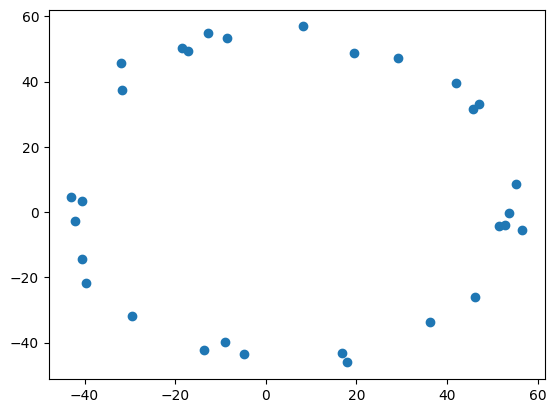

In [322]:
# Global variables
MAP_SIZE = 100
NUMBER_CITIES = 30

city_map = create_map(NUMBER_CITIES,MAP_SIZE)
show_map(city_map)


# Genetic Algorithm
This section will define the genetic algortihm for the travel salesman problem.

In [331]:
"""
Class representing an individual
Args:
    gene: array of ints, order of cities to visit
    city_map: map of the cities to be visited
    mutation_rate: probability of mutation to occour
"""   
class Individual():
    def __init__(self, gene, city_map, mutation_rate=0.1):
        self.gene = gene
        self.path = self.gene
        self.path.append(self.path[0])
        self.city_map = city_map
        self.mutation_rate = mutation_rate
        self.fitness = self.fitness()
        
    
    """
    Define fitness of the individual
    Return:
        accumulative sum of euclidean distances between the cities
    """   
    def fitness(self):
        result = 0
        for i in range(len(self.path)-2):
            result += np.linalg.norm(np.array(self.city_map[self.path[i]])-np.array(self.city_map[self.path[i+1]]))
        return result
        #return math.log(result)
    
    """
    Mutate individual by swapping positions in two cities
    """   
    def mutate(self):
        for swapped in range(len(self.gene)):
            if(random.random() < self.mutation_rate):
                swapWith = int(random.random() * len(self.gene))
                
                city1 = self.gene[swapped]
                city2 = self.gene[swapWith]
                
                self.gene[swapped] = city2
                self.gene[swapWith] = city1

    """
    Produce one ofspring with another individual
    Args:
        parent2: Individual that will share genes
    Return:
        last individual.
    """   
    def breed(self, parent2):
        child = []
        childP1 = []
        childP2 = []
        
        geneA = int(random.random() * len(self.gene))
        geneB = int(random.random() * len(self.gene))
        
        startGene = min(geneA, geneB)
        endGene = max(geneA, geneB)

        for i in range(startGene, endGene):
            childP1.append(self.gene[i])
            
        childP2 = [item for item in parent2.gene if item not in childP1]

        child = childP1 + childP2
        return Individual(child,city_map)

    """
    Print gene of individual
    """   
    def to_string(self):
        return self.gene
    

"""
Class for genetic algorithm
Args:
    population_size: number of individuals in population
    mutation_rate: probability of mutation to occour
    epochs: number of max generations to run
    city_map: map of the cities to be visited
    patience: number of epochs without decrease in fitness before stopping
"""   
class GA():
    def __init__(self, population_size, city_map, mutation_rate=.1, epochs=100, patience=5):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.epochs = epochs
        self.city_map = city_map
        self.map_size = len(city_map)
        self.patience = patience
        self.patience_epochs = 0
        self.best_fit = None
        self.population = self.initial_population()
    
    """
    Generate first population at random
    Return:
        list of individuals
    """   
    def initial_population(self):
        population =  []
        for _ in range(self.population_size):
            individual = list(range(self.map_size))
            random.shuffle(individual)
            population.append(Individual(individual,self.city_map,self.mutation_rate))
        return population
    """
    Sorts population by lowest distance
    """   
    def sort_population(self):
        self.population.sort(key=lambda x: x.fitness)        

    """
    Reproduce populaton by keeping half the population size from previous generation
    and generating new individuals by randomly picking parents until popluation coes back
    to original size.
    """  
    def reproduce(self):
        elite_size = int(self.population_size/2)
        self.population = self.population[:elite_size]
        while len(self.population) < self.population_size:
            parent1 = int(random.random() * elite_size)
            parent2 = int(random.random() * elite_size)
            child = self.population[parent1].breed(self.population[parent2])
            child.mutate()
            self.population.append(child)

    """
    Evolve population until epochs are over or population has converged
    Return:
        list of avg fitness by generation
        list of best fitness by generation
    """
    def evolve(self):
        avarage_fitness = []
        best_fitness = []
        best_individual = []
        for _ in range(self.epochs):
            self.sort_population()
            best_fitness.append(self.population[0].fitness)
            best_individual.append(self.population[0])
            avarage_fitness.append(self.avg_fit())
            self.reproduce()
            if self.patience and self.early_stopper():
                self.mutation_rate *= 1.5
        return avarage_fitness, best_fitness, best_individual
    
    """
    Updates best fit and patience epochs based on best result of generation
    """   
    def update_early_stopper(self):
        if self.best_fit and self.best_fit > self.population[0].fitness:
            self.best_fit = self.population[0].fitness
            self.patience_epochs = 0
        if self.best_fit and self.best_fit <= self.population[0].fitness:
            self.patience_epochs += 1
        if not self.best_fit:
            self.best_fit = self.population[0].fitness
    
    """
    Decides to stop evolution if best fitness doesn't increase within predefined generations
    Return:
        boolean whether the amount of epochs without better results is equal to patience
    """   
    def early_stopper(self):
        self.update_early_stopper()
        if self.patience_epochs == self.patience:
            return True
        else:
            return False

    """
    Calculates avarage fitness of a generation
    Return:
        avg fitness by generation
    """        
    def avg_fit(self):
        result = 0
        for x in self.population:
            result += x.fitness
        return result/self.population_size
    
    """
    Prints individuals and fitness sorted by lowest fitness
    """
    def print_population(self):
        self.sort_population()
        for x in self.population:
            print(f"{x.fitness}:{x.to_string()}")
        


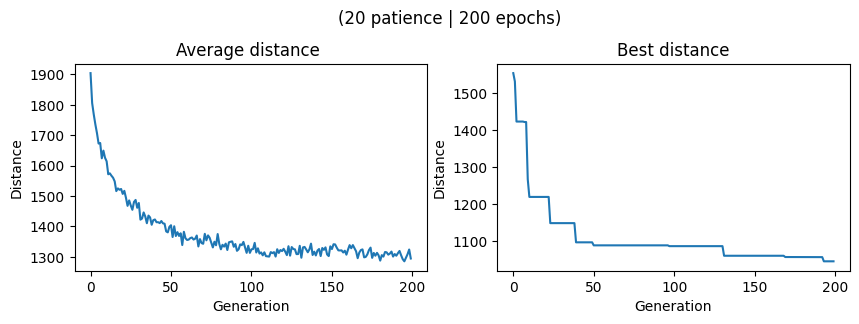

In [332]:
# Showcase importance of early stopper
ga = GA(100, city_map,epochs=200, patience=20, mutation_rate=.5)
avarage_fitness, best_fitness, best_paths = ga.evolve()
plot_ga(avarage_fitness,best_fitness, ga.patience, ga.epochs)

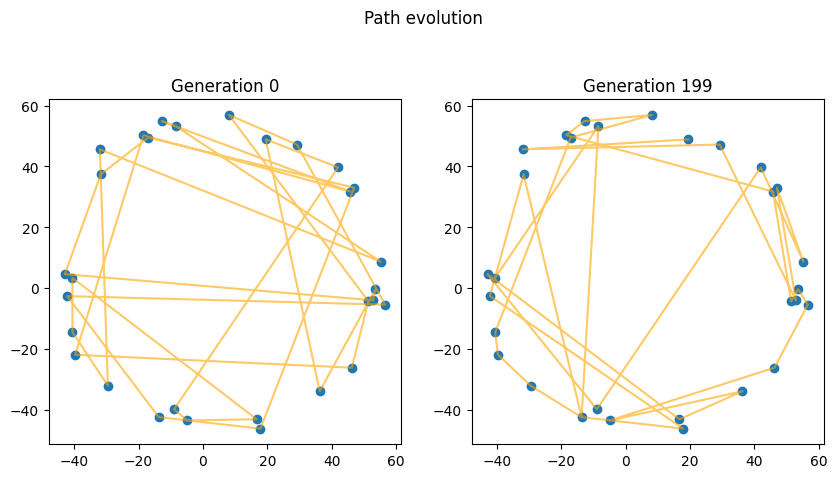

In [333]:
plot_path_evolution(city_map,best_paths)

# Particle Swarm Optimization
This section will implement particle swarm optimization for the travel salesman problem.

In [ ]:
class PSO():
    def __init__(self):
        